In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
import numpy as np
import pandas as pd
import zipfile
import urllib.request
import os
from os import listdir
import cv2

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from PIL import Image
from glob import glob
from skimage.io import imread

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.optim as optim

import time
import copy
from tqdm import tqdm_notebook as tqdm

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
! pip install opendatasets
! pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shrashtisaraswat","key":"4ec8460e0085f4797a68f9207e9ef47c"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets list

ref                                                         title                                         size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  -------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                       Data Science Salaries 2023  💸                 25KB  2023-04-13 09:55:16           6012        150  1.0              
salvatorerastelli/spotify-and-youtube                       Spotify and Youtube                            9MB  2023-03-20 15:43:25          11531        403  1.0              
iammustafatz/diabetes-prediction-dataset                    Diabetes prediction dataset                  734KB  2023-04-08 06:11:45           3085         53  1.0              
shawkyelgendy/furniture-price-prediction                    Furniture Price Prediction                    81KB  202

In [ ]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.31G/6.31G [04:37<00:00, 25.5MB/s]
100% 6.31G/6.31G [04:37<00:00, 24.4MB/s]


#### Extract the csv file from the zip file


In [ ]:
with zipfile.ZipFile('/content/histopathologic-cancer-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [ ]:
train_path = '/content/train'
test_path = '/content/test'
train_files = os.listdir(train_path)
test_files = os.listdir(test_path)

In [ ]:
labels = pd.read_csv("/content/train_labels.csv")
labels.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

In [ ]:
labels.shape

(220025, 2)

In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [ ]:
print("Train size: ",len(train_files))
print("Test size: ",len(test_files))

Train size:  220025
Test size:  57458


In [ ]:
print((len(train_files)/(len(train_files)+len(test_files)))*100, (len(test_files)/(len(train_files)+len(test_files)))*100)

79.29314588641466 20.706854113585337


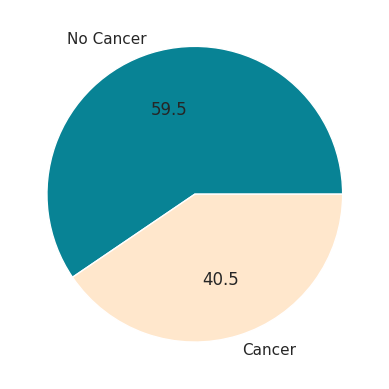

In [ ]:
plt.pie(labels.label.value_counts(), labels=['No Cancer', 'Cancer'], colors=['#088395', '#FFE7CC'], autopct='%1.1f')
plt.show()

In [ ]:
positive_images = np.random.choice(labels[labels.label==1].id, size=50, replace=False)
negative_images = np.random.choice(labels[labels.label==0].id, size=50, replace=False)

Positive Images

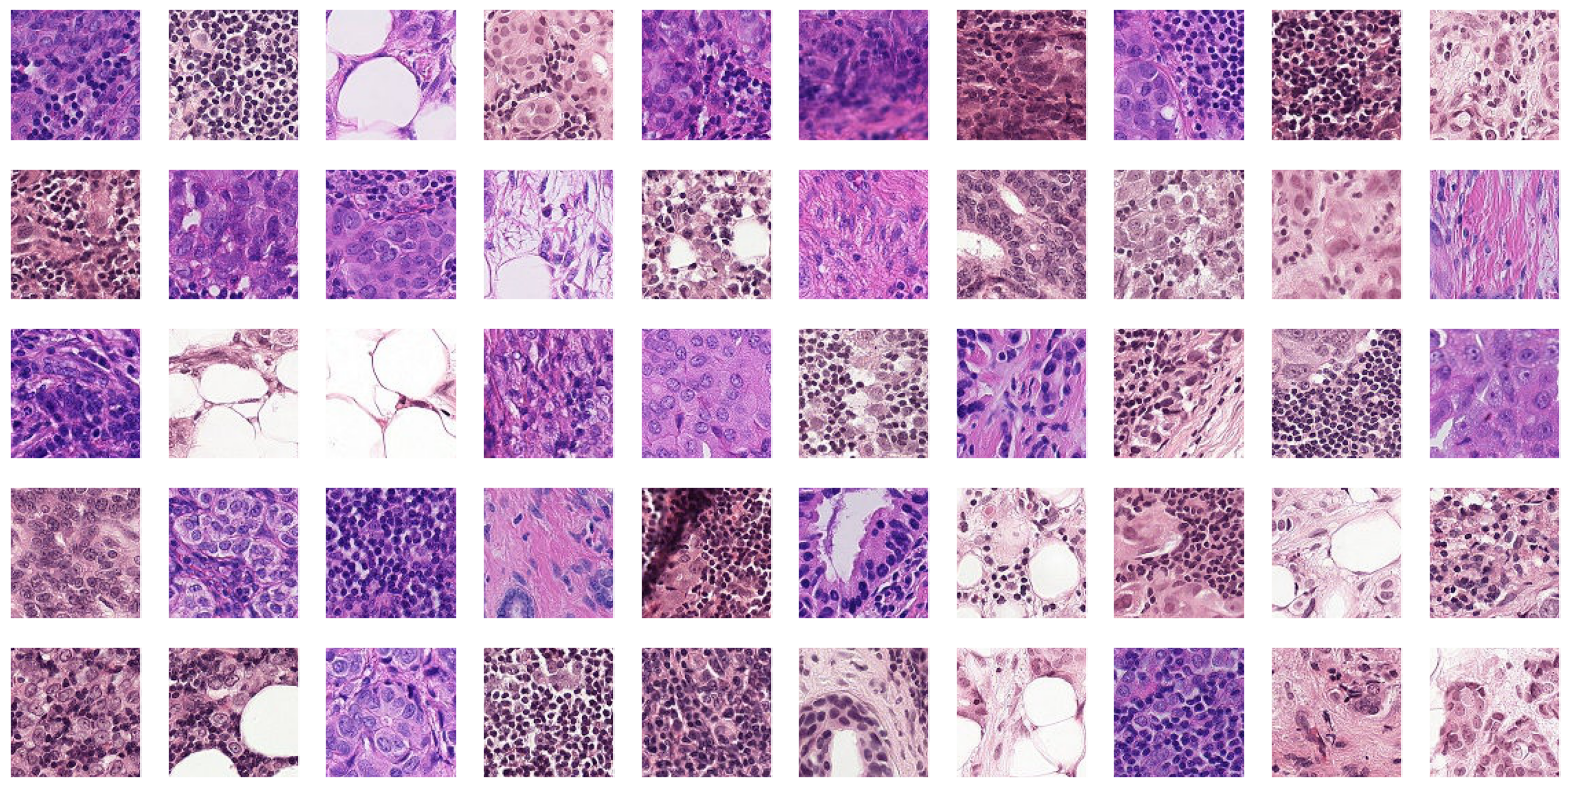

In [ ]:
fig, ax = plt.subplots(5, 10, figsize=(20,10))

for n in range(5):
    for m in range(10):
        img_id = positive_images[m + n*10]
        image = Image.open(train_path+"/" + img_id + ".tif")
        ax[n,m].imshow(image)
        ax[n,m].grid(False)
        ax[n,m].tick_params(labelbottom=False, labelleft=False)

Negative images

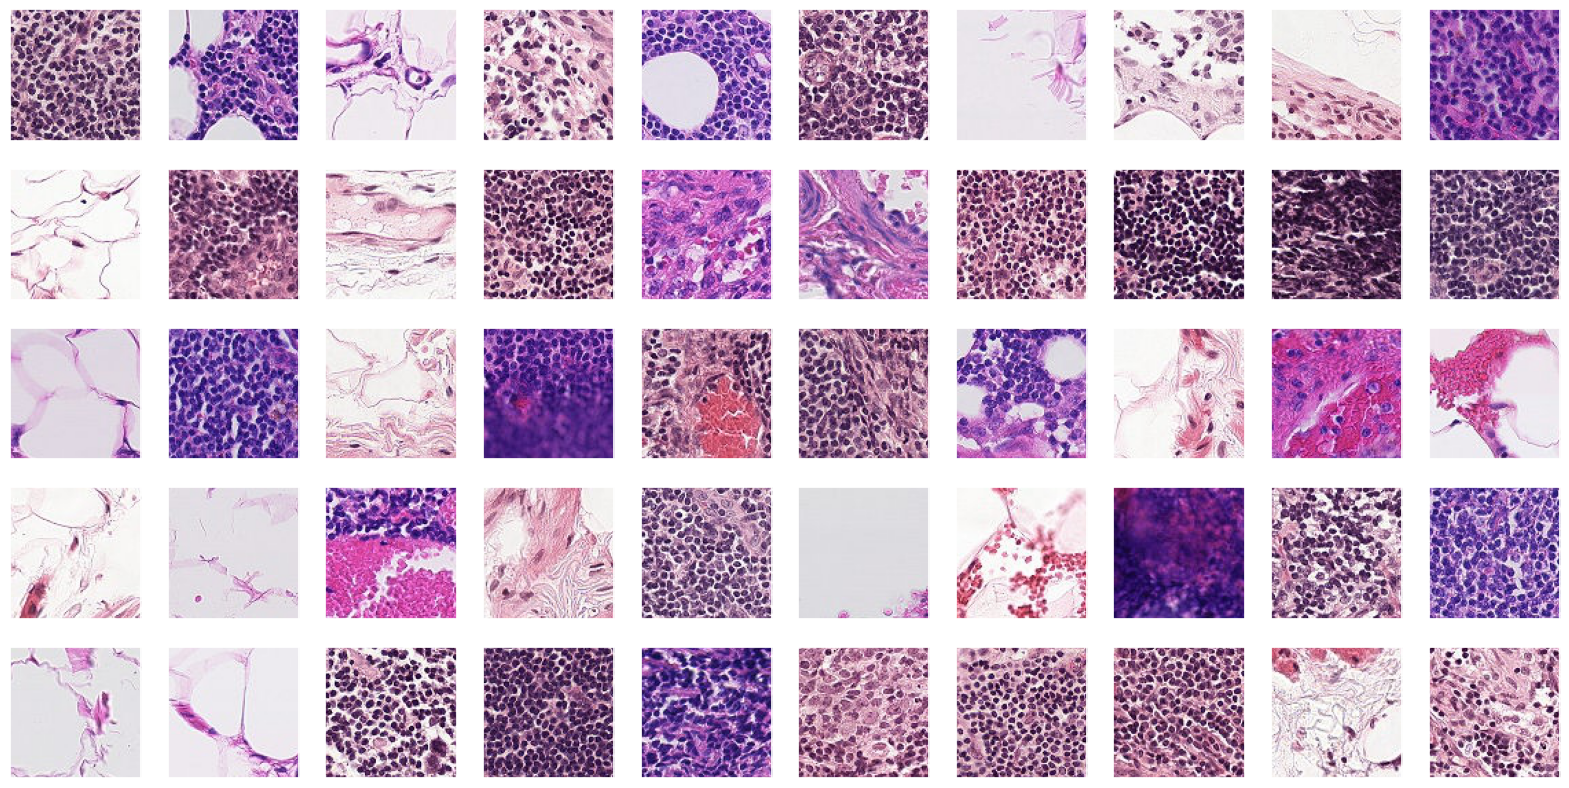

In [ ]:
fig, ax = plt.subplots(5, 10, figsize=(20,10))

for n in range(5):
    for m in range(10):
        img_id = negative_images[m + n*10]
        image = Image.open(train_path +"/"+ img_id + ".tif")
        ax[n,m].imshow(image)
        ax[n,m].grid(False)
        ax[n,m].tick_params(labelbottom=False, labelleft=False)

Spliting the dataset into training and validation sets


In [ ]:
train_data= train_files
test_data= test_files
train, val = train_test_split(labels, stratify=labels.label, test_size=0.1)

Dataset class for image classification

In [ ]:
'''The Dataset class takes a data dataframe, data directory, and transform as input.
The __len__ function returns the length of the dataset, which is the number of images in the dataframe.
The __getitem__ function takes an index as input and returns the image and label at that index.
The image is loaded from the data directory using the image name and transformed if a transform is provided'''

class Dataset(Dataset):
    def __init__(self, data_df, data_dir = './', transform=None):
        super().__init__()
        self.df = data_df.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name + '.tif')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

###Image Preprocessing

In [ ]:
batch_size = 128
valid_size = 0.1

path='/content/train'

In [ ]:
'''Creating two DataLoader objects train_loader
object is initialized with the dataset_train object
and valid_loader object is initialized dataset_valid'''

trans_train = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(64, padding_mode='reflect'),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomVerticalFlip(),
                                  transforms.RandomRotation(20),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

trans_valid = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(64, padding_mode='reflect'),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

dataset_train = Dataset(data_df=train, data_dir=path, transform=trans_train)
dataset_valid = Dataset(data_df=val, data_dir=path, transform=trans_valid)

train_loader = DataLoader(dataset = dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset = dataset_valid, batch_size=batch_size//2, shuffle=False, num_workers=0)



###Model Definition

#####CNN using the PyTorch framework

In [ ]:
'''This CNN architecture consists of 5 convolutional layers and a fully connected layer,
with max pooling and batch normalization applied after each convolutional layer. The
input to the CNN is a 3-channel image, and the output is a binary classification label (0 or 1).'''

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=2),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.avg = nn.AvgPool2d(8)
        self.fc = nn.Linear(512 * 1 * 1, 2)

    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avg(x)
        x = x.view(-1, 512 * 1 * 1)
        x = self.fc(x)
        return x

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNor

####Loss function and optimization

In [ ]:
criterion=nn.CrossEntropyLoss()

learning_rate=0.002
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [ ]:
num_epochs = 10
total_step = len(train_loader)
for epoch in range(num_epochs):

    train_loss = 0.0
    valid_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        output = model(images)
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*images.size(0)

        train_loss = train_loss/len(train_loader.sampler)

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/10], Step [100/1548], Loss: 0.4066
Epoch [1/10], Step [200/1548], Loss: 0.4331
Epoch [1/10], Step [300/1548], Loss: 0.3706
Epoch [1/10], Step [400/1548], Loss: 0.4438
Epoch [1/10], Step [500/1548], Loss: 0.4884
Epoch [1/10], Step [600/1548], Loss: 0.3435
Epoch [1/10], Step [700/1548], Loss: 0.4629
Epoch [1/10], Step [800/1548], Loss: 0.2688
Epoch [1/10], Step [900/1548], Loss: 0.3225
Epoch [1/10], Step [1000/1548], Loss: 0.2443
Epoch [1/10], Step [1100/1548], Loss: 0.2836
Epoch [1/10], Step [1200/1548], Loss: 0.2700
Epoch [1/10], Step [1300/1548], Loss: 0.1795
Epoch [1/10], Step [1400/1548], Loss: 0.2610
Epoch [1/10], Step [1500/1548], Loss: 0.2938
Epoch [2/10], Step [100/1548], Loss: 0.3323
Epoch [2/10], Step [200/1548], Loss: 0.2185
Epoch [2/10], Step [300/1548], Loss: 0.3188
Epoch [2/10], Step [400/1548], Loss: 0.1811
Epoch [2/10], Step [500/1548], Loss: 0.2025
Epoch [2/10], Step [600/1548], Loss: 0.2653
Epoch [2/10], Step [700/1548], Loss: 0.1787
Epoch [2/10], Step [800/15

In [ ]:
'''The training loop updates the model parameters using the Adam optimizer and
computes the training loss, accuracy, and AUC for each batch. At the end of each
epoch, it evaluates the model on the validation dataset, computes validation loss,
accuracy, and AUC, and prints out the results.'''

num_epochs=10
total_step=len(train_loader)

for epoch in range(num_epochs):

    train_loss = 0.0
    valid_loss = 0.0
    correct = 0
    total = 0
    val_auc = 0.0
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        output = model(images)
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*images.size(0)
        _, predicted = torch.max(output.data, 1)   #calculating accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_loss = train_loss/len(train_loader.sampler)

        output_prob = torch.sigmoid(output)      #Calculating AUC
        output_prob = output_prob.cpu().detach().numpy()
        labels = labels.cpu().numpy()
        val_auc += roc_auc_score(labels, output_prob[:,1])

        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%, AUC: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item(),100 * correct/total, val_auc/(i+1)))

#Evaluating
    model.eval()
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            loss = criterion(output, labels)
            valid_loss += loss.item()*images.size(0)

            #calculating accuracy
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            #calculating AUC
            output_prob = torch.sigmoid(output)
            output_prob = output_prob.cpu().detach().numpy()
            labels = labels.cpu().numpy()
            val_auc += roc_auc_score(labels, output_prob[:,1])

    valid_loss = valid_loss/len(valid_loader.sampler)
    val_auc = val_auc/len(valid_loader)

    print('Epoch [{}/{}], Training Loss: {:.4f}, Validation Loss: {:.4f}, Accuracy: {:.2f}%, AUC: {:.4f}'
           .format(epoch+1, num_epochs, train_loss, valid_loss, 100 * correct/total, val_auc))

Epoch [1/10], Step [100/1548], Loss: 0.2713, Accuracy: 88.81%, AUC: 0.9546
Epoch [1/10], Step [200/1548], Loss: 0.3727, Accuracy: 88.75%, AUC: 0.9542
Epoch [1/10], Step [300/1548], Loss: 0.2782, Accuracy: 88.79%, AUC: 0.9546
Epoch [1/10], Step [400/1548], Loss: 0.1837, Accuracy: 88.85%, AUC: 0.9544
Epoch [1/10], Step [500/1548], Loss: 0.2604, Accuracy: 89.01%, AUC: 0.9556
Epoch [1/10], Step [600/1548], Loss: 0.2097, Accuracy: 89.18%, AUC: 0.9568
Epoch [1/10], Step [700/1548], Loss: 0.1647, Accuracy: 89.29%, AUC: 0.9578
Epoch [1/10], Step [800/1548], Loss: 0.1758, Accuracy: 89.50%, AUC: 0.9592
Epoch [1/10], Step [900/1548], Loss: 0.1545, Accuracy: 89.62%, AUC: 0.9599
Epoch [1/10], Step [1000/1548], Loss: 0.2447, Accuracy: 89.75%, AUC: 0.9606
Epoch [1/10], Step [1100/1548], Loss: 0.3846, Accuracy: 89.89%, AUC: 0.9614
Epoch [1/10], Step [1200/1548], Loss: 0.2157, Accuracy: 90.02%, AUC: 0.9622
Epoch [1/10], Step [1300/1548], Loss: 0.1908, Accuracy: 90.15%, AUC: 0.9631
Epoch [1/10], Step [1